# Kernel Tuner Backends Test

This notebook is intended to examine performance differences in the Kernel Tuner backends.

In [5]:
from pathlib import Path
import json
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from warnings import warn

In [6]:
# arguments
kernels = ["gemm_cltune_cuda", "gemm_cltune_opencl"]
kernels = ["gemm_opencl", "gemm_opencl_cuda"]
expected_keys = ['time', 'times', 'GFLOP/s', 'compile_time', 'benchmark_time', 'framework_time', 'strategy_time', 'REPEAT']
observer_keys = ['mem_freq', 'core_freq', 'temperature', 'num_regs']
backend_displaynames = {
    'CUDA': 'PyCUDA',
    'CUPY': 'CuPy',
    'NVCUDA': 'CUDA-Python',
    'OpenCL': 'OpenCL'
}
# backends = sorted(list(backend_displaynames.values()))
cuda_versions = ['11.2', '12.3', 'N/A ']
plot_height = 6
plot_aspect = 2.0

In [7]:
def get_dataframe(observers=False, old_data=False, no_flush=False) -> pd.DataFrame:

    # collect the relevant cachefiles
    cachefiles : list[Path] = []
    for kernel in kernels:
        # get the path to the cachefiles directory
        if old_data:
            folder_clock = "variable_clock_size-4096"
            folder_observers = "observers" if observers else "no_observers"
            cachefiles_path = Path("kernels/outputdata").resolve() / folder_clock / folder_observers
        else:
            cachefiles_path = Path("kernels/outputdata").resolve() / kernel
            if no_flush:
                cachefiles_path = cachefiles_path / "no_flush"
        assert cachefiles_path.exists()

        # get all relevant cachefiles
        for file in cachefiles_path.iterdir():
            if file.is_file() and file.name.startswith(kernel) and "_noisetest" in file.name and "_cache" in file.name and file.suffix == '.json':
                cachefiles.append(file)

    # create a list of dictionaries of the data
    cache_dicts = list()
    for filepath in cachefiles:
        try:
            cachefile = json.load(filepath.open())
        except json.JSONDecodeError:
            warn(f"Could not load cachefile {filepath.name}")
            continue
        device_name = cachefile['device_name']
        backend = backend_displaynames[re.search(r"_backend-([a-zA-Z]+)_", filepath.name).group(1).strip()]
        is_cuda_kernel = "_CUDA-" in filepath.name
        if is_cuda_kernel:
            CUDA_version = re.search(r"_CUDA-(.*)_", filepath.name).group(1).strip()
        else:
            CUDA_version = "N/A "
        CUDA_backend= f"c:{CUDA_version} | b:{backend}"
        backend_CUDA = f"b:{backend} | c:{CUDA_version}"
        # for each of the configurations, create a dictionary with the expected items
        for value in cachefile['cache'].values():
            assert isinstance(value, dict)
            cache = {}
            cache['device_name'] = device_name
            cache['backend'] = backend
            cache['backend | CUDA version'] = backend_CUDA
            cache['CUDA version | backend'] = CUDA_backend
            cache['CUDA version'] = CUDA_version
            for key in expected_keys:
                cache[key] = value[key]
            cache['total_time'] = value['compile_time'] + value['benchmark_time'] + value['framework_time']
            if observers:
                for key in observer_keys:
                    if key in value:
                        cache[key] = value[key]
            cache_dicts.append(cache)

    # create a dataframe out of the dictionaries
    df_ = pd.DataFrame(cache_dicts)
    return df_.sort_values(['CUDA version', 'backend'])

In [8]:
df = get_dataframe(observers=False)
backends = df['backend'].unique()

/var/folders/rm/r40v9t112655gv73gcclld2w0000gn/T/ipykernel_29811/2970602970.py:28: UserWarning: Could not load cachefile gemm_cltune_cuda_NVIDIA_RTX_A4000_size-4096x4096x4096_noisetest_backend-CUDA_CUDA-12.3_cache.json
  warn(f"Could not load cachefile {filepath.name}")
/var/folders/rm/r40v9t112655gv73gcclld2w0000gn/T/ipykernel_29811/2970602970.py:28: UserWarning: Could not load cachefile gemm_cltune_cuda_NVIDIA_RTX_A4000_size-4096x4096x4096_noisetest_backend-NVCUDA_CUDA-12.3_cache.json
  warn(f"Could not load cachefile {filepath.name}")


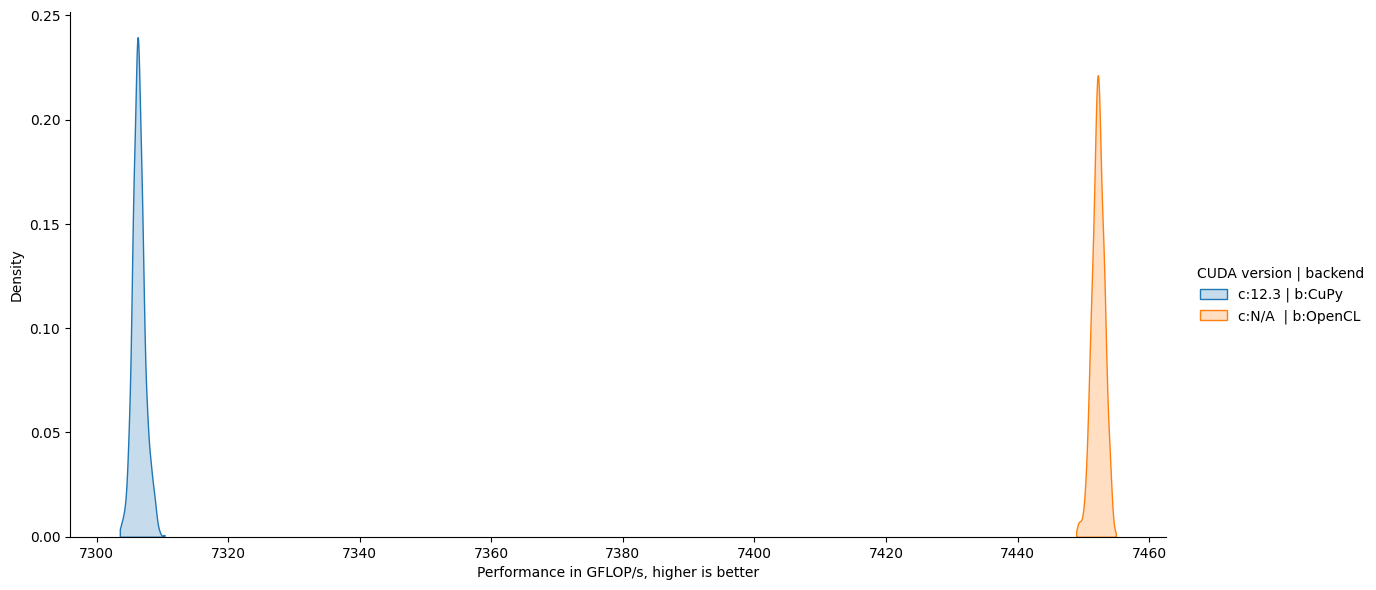

In [9]:
g = sns.displot(data=df, x='GFLOP/s', hue='CUDA version | backend', kind='kde', fill=True, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Performance in GFLOP/s, higher is better")

The figure above shows a histogram for each combination of CUDA version and backend. The difference in performance between the CUDA 11.2 and 12.3 is quite visible. Whereas with PYCUDA CUDA 11.2 slightly outperforms 12.3, for CuPy the difference is noticeable. CUDA-Python performs very similarly to CuPy, even having the same distribution shape. In general, none of the backends demonstrate large variation in performance. 

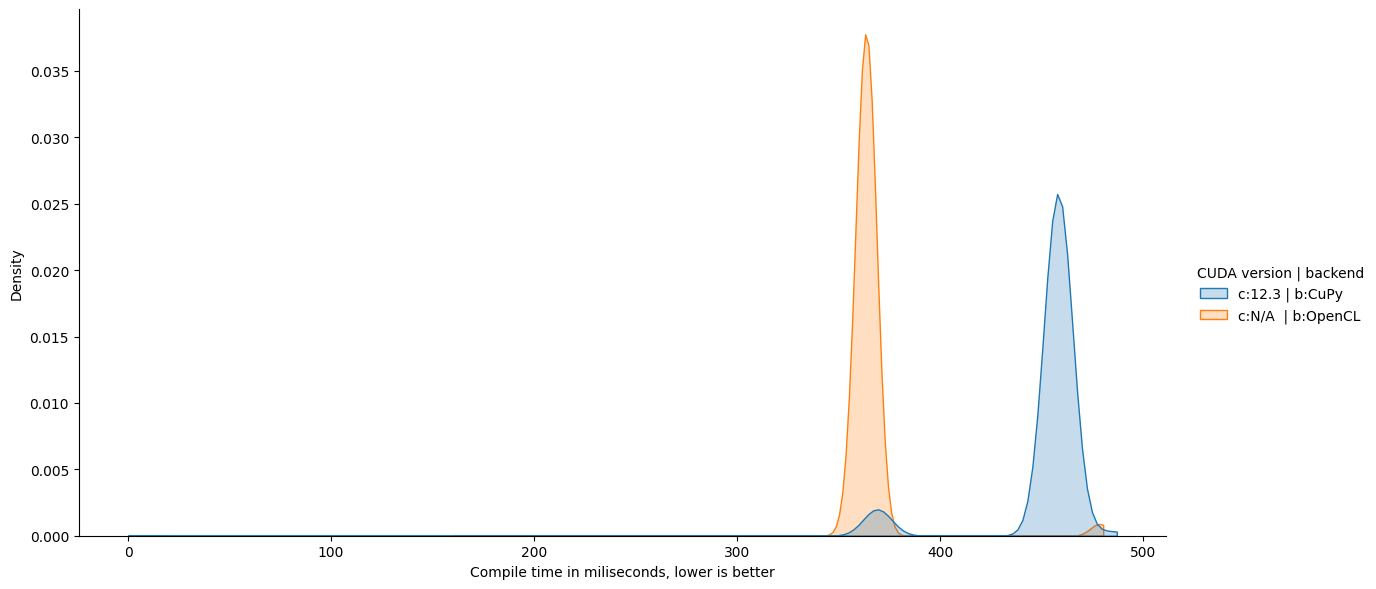

In [10]:
g = sns.displot(data=df, x='compile_time', hue='CUDA version | backend', kind='kde', fill=True, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Compile time in miliseconds, lower is better")

Interestingly, the backends that provided the best performance in the previous plot (CuPy at 12.3 and CUDA-Python), also perform best in terms of compile time. The CuPy compile time on CUDA 12.3 is very similar to that of CUDA-Python as they both use NVRTC, whereas PyCUDA uses NVCC. 

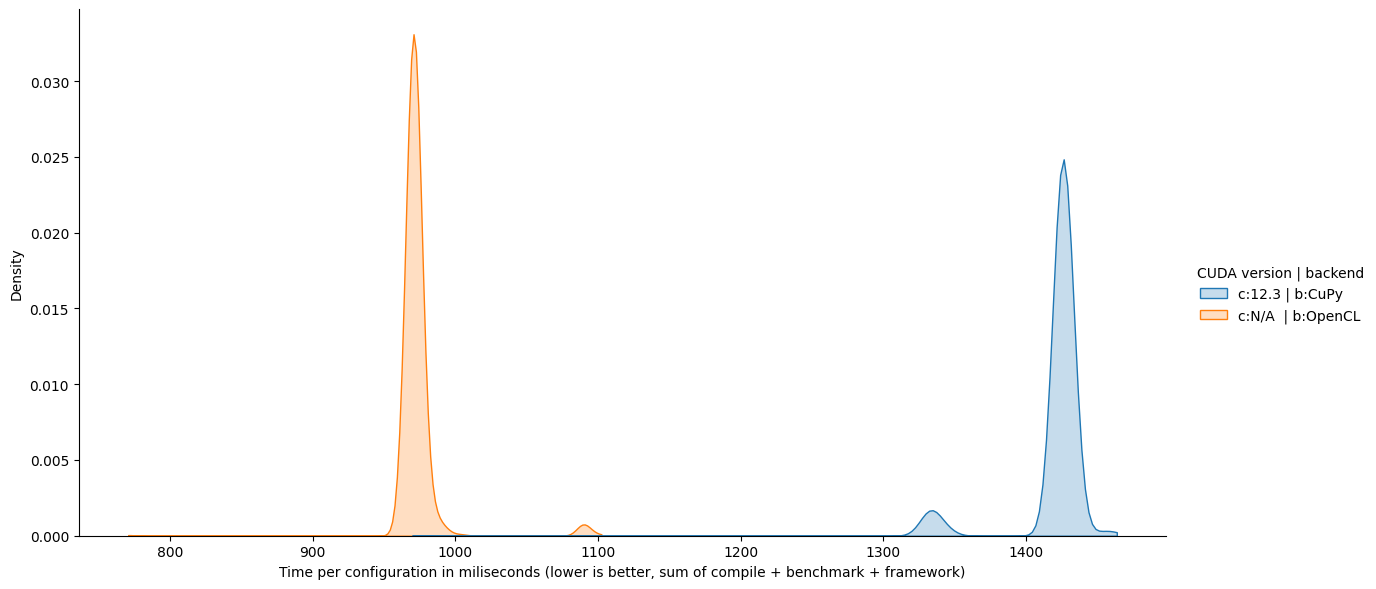

In [11]:
g = sns.displot(data=df, x='total_time', hue='CUDA version | backend', kind='kde', fill=True, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Time per configuration in miliseconds (lower is better, sum of compile + benchmark + framework)")

Looking at the distribution of the total time per configuration, CuPy and CUDA-Python on CUDA 12.3 are the fastest overall, as expected given that they are fastest to compile and produce the best performing kernels. The large difference with CuPy on CUDA 11.2 and PyCUDA on CUDA 12.3 is quite important, as it implies that for a searchspace too large to explore exhaustively, ~18.5% more configurations can be explored in the same amount of time by simply choosing a different backend.

Text(0, 0.98, 'backend | CUDA version')

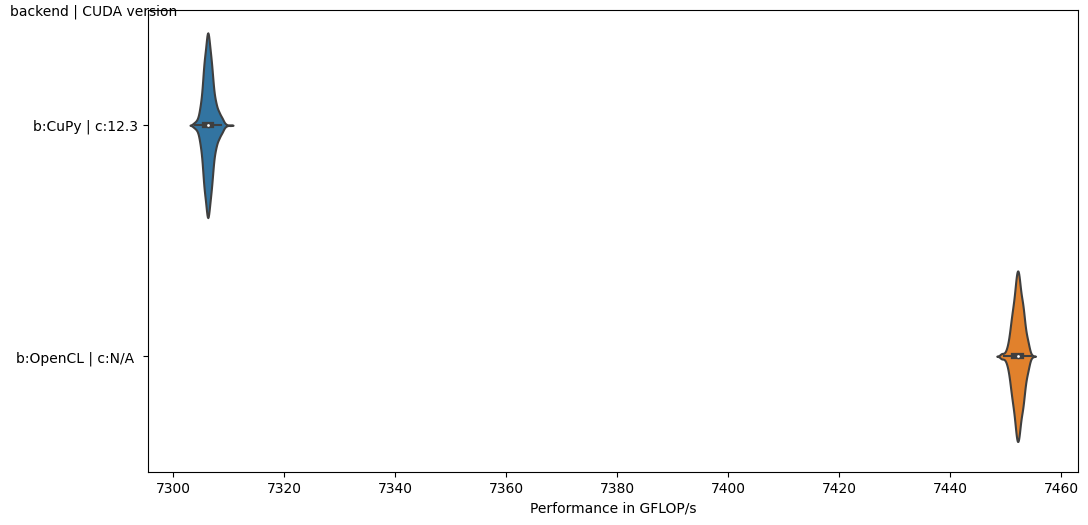

In [12]:
fig = plt.gcf()
fig.set_size_inches(plot_aspect*plot_height, plot_height)
g = sns.violinplot(data=df, x='GFLOP/s', y='backend | CUDA version')
g.set_xlabel("Performance in GFLOP/s")
g.set_ylabel('backend | CUDA version', rotation=0, y=.98, horizontalalignment='left')

## Investigating with Observers

In [13]:
df = get_dataframe(observers=True)

/var/folders/rm/r40v9t112655gv73gcclld2w0000gn/T/ipykernel_29811/2970602970.py:28: UserWarning: Could not load cachefile gemm_cltune_cuda_NVIDIA_RTX_A4000_size-4096x4096x4096_noisetest_backend-CUDA_CUDA-12.3_cache.json
  warn(f"Could not load cachefile {filepath.name}")
/var/folders/rm/r40v9t112655gv73gcclld2w0000gn/T/ipykernel_29811/2970602970.py:28: UserWarning: Could not load cachefile gemm_cltune_cuda_NVIDIA_RTX_A4000_size-4096x4096x4096_noisetest_backend-NVCUDA_CUDA-12.3_cache.json
  warn(f"Could not load cachefile {filepath.name}")


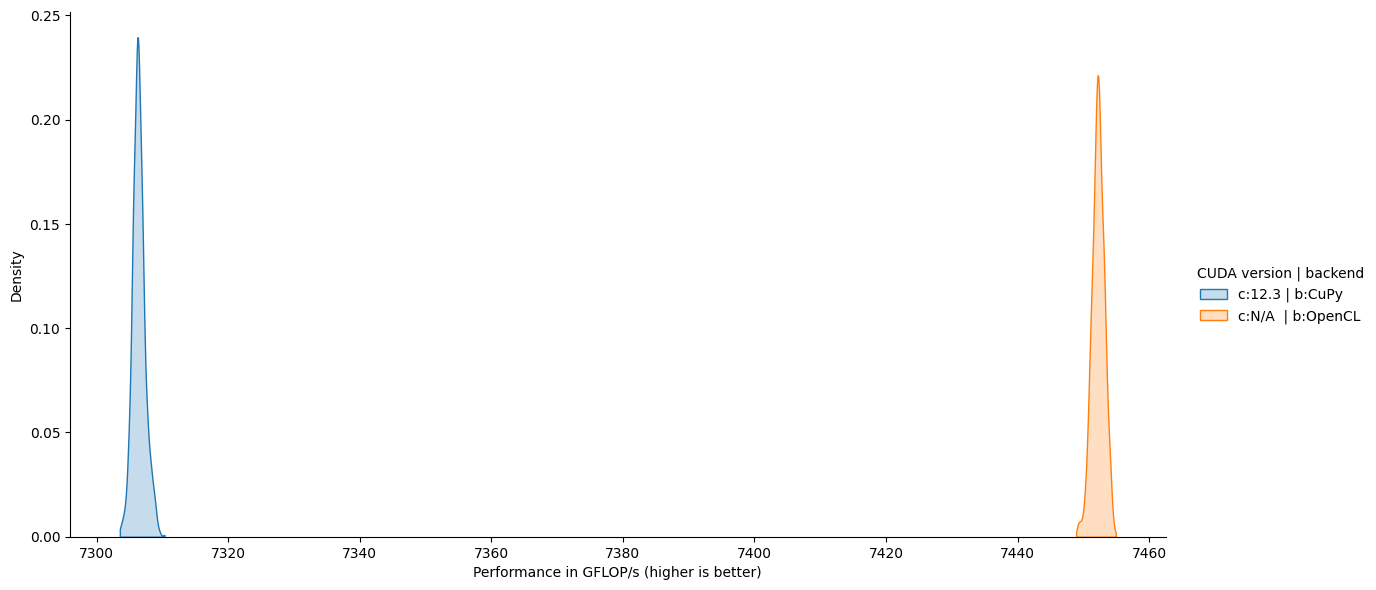

In [14]:
g = sns.displot(data=df, x='GFLOP/s', hue='CUDA version | backend', kind='kde', fill=True, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Performance in GFLOP/s (higher is better)")

Sanity check: do we still see the same distributions with observers as we did without?

Text(0, 0.5, 'Average number of registers used')

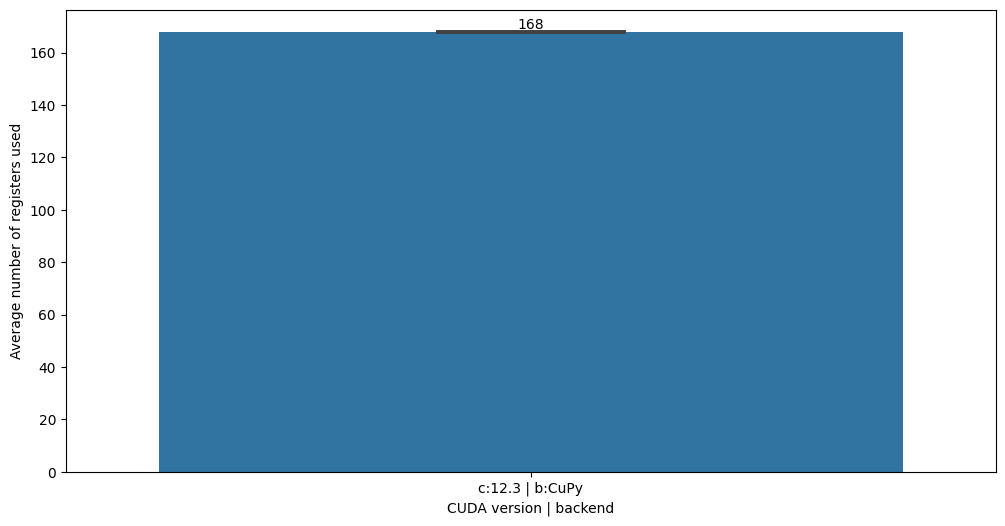

In [15]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height))
g = sns.barplot(data=df.loc[df['backend'] != 'OpenCL'], x='CUDA version | backend', y="num_regs", estimator=np.mean, errorbar='sd', capsize=.2)
g.bar_label(g.containers[0])
g.set_ylabel("Average number of registers used")

Looking at the average number of registers, there are no differences. 

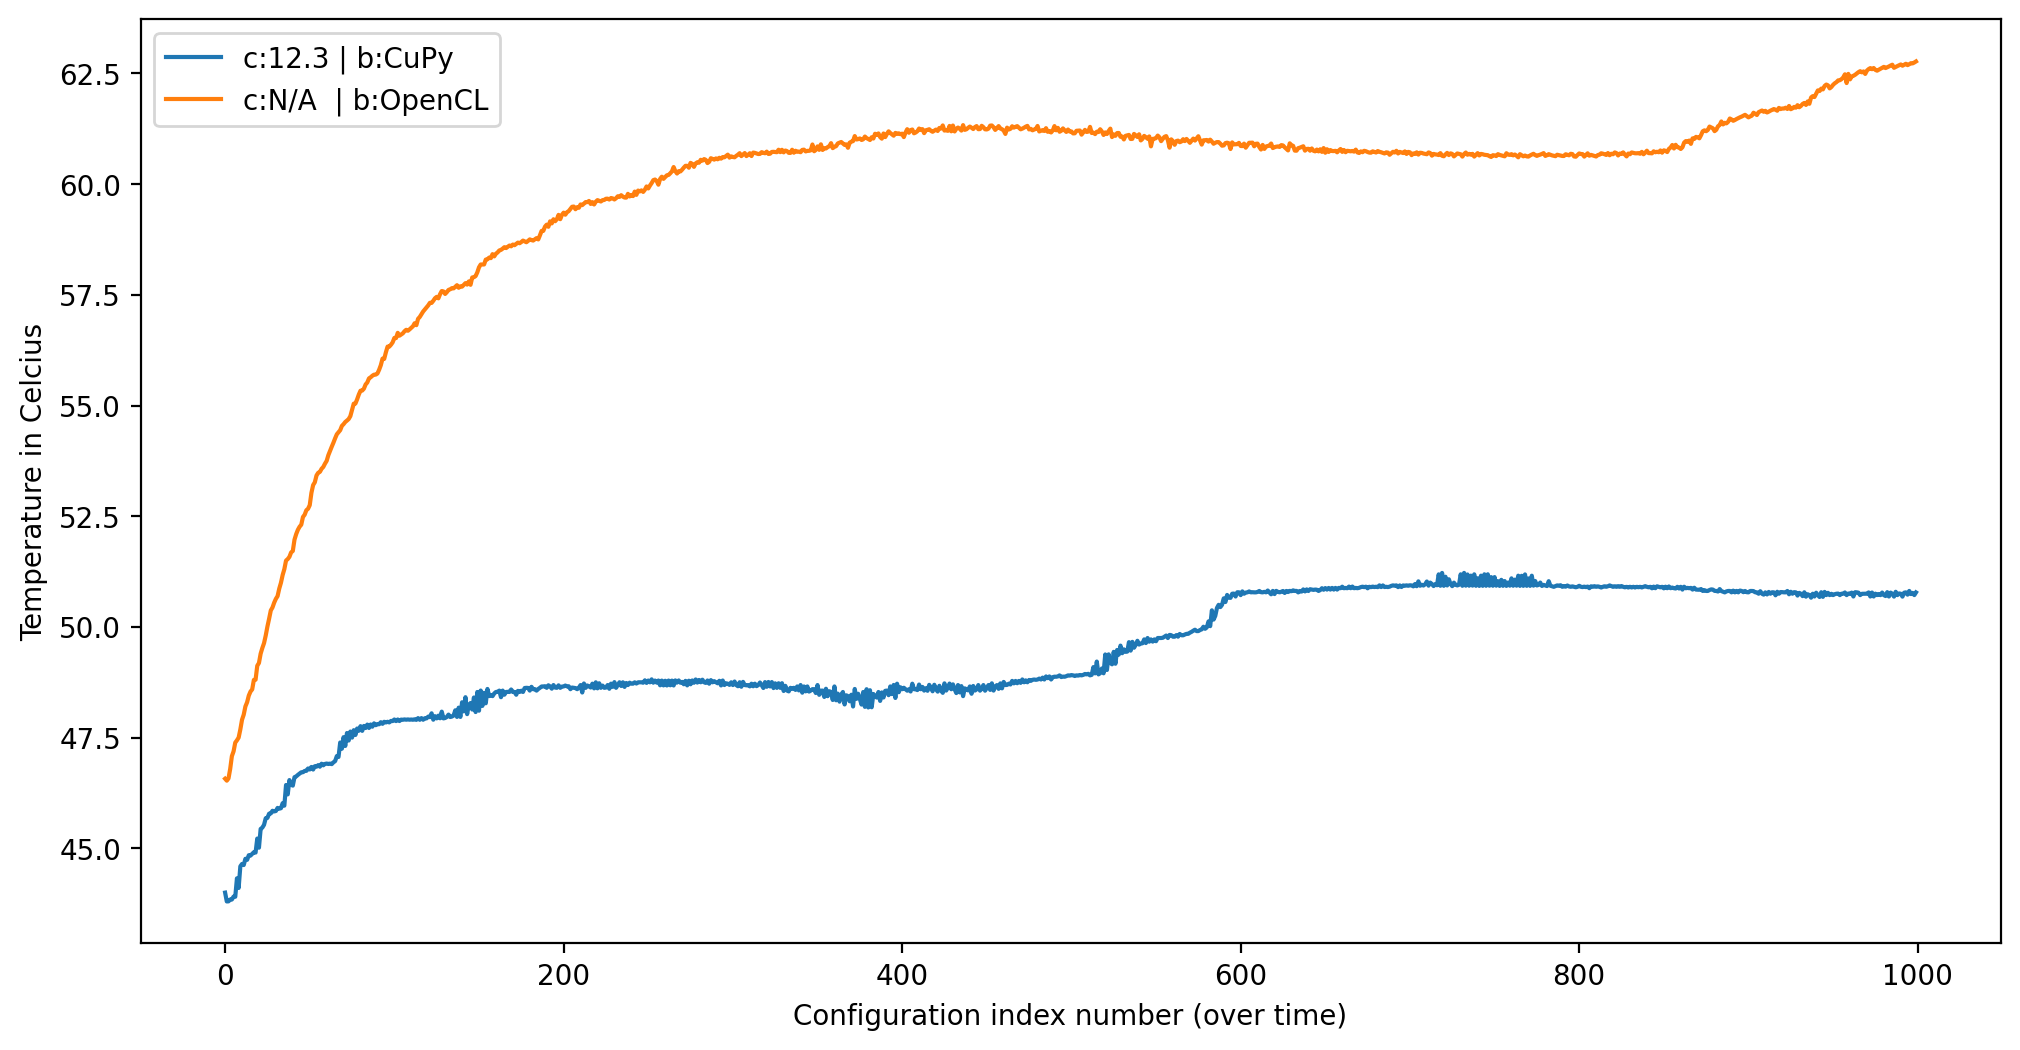

In [16]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height), dpi=200)
for cuda_version in sorted(cuda_versions):
    for backend in sorted(backends):
        f_df = df.loc[(df['backend'] == backend) & (df['CUDA version'] == cuda_version)]
        if f_df.size > 0:
            sns.lineplot(data=f_df.sort_values(['temperature']), y='temperature', x='REPEAT', label=f_df['CUDA version | backend'].iloc[0])
plt.ylabel("Temperature in Celcius")
plt.xlabel("Configuration index number (over time)")
plt.legend()

If we look at the temperature of each backend, it is interesting to note that while the core and memory clock frequencies have been fixed, there are temperature differences between the backends. 

Text(0, 0.5, 'Average core clock frequency')

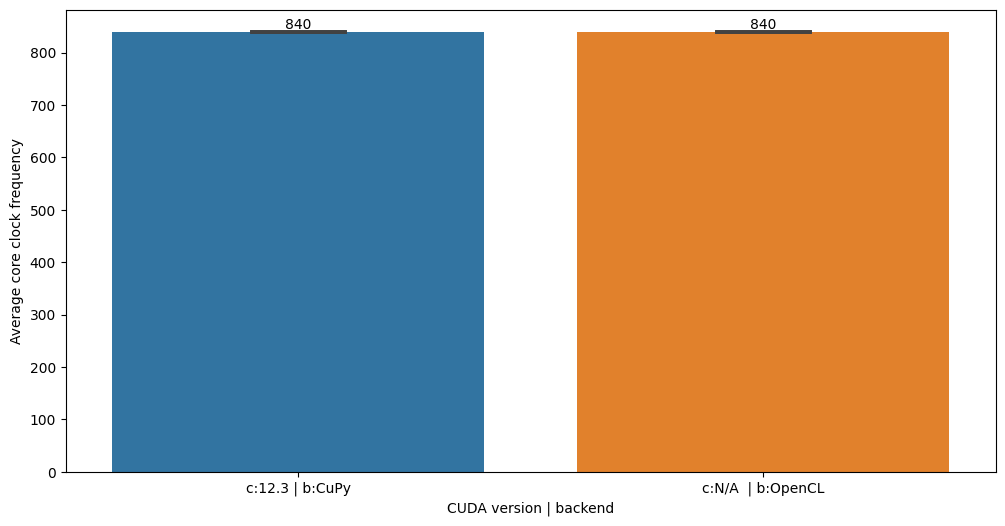

In [26]:
plt.figure(figsize=(plot_aspect*plot_height, plot_height))
g = sns.barplot(data=df, x='CUDA version | backend', y="core_freq", estimator=np.mean, errorbar='sd', capsize=.2)
g.bar_label(g.containers[0])
g.set_ylabel("Average core clock frequency")

Finally, we can ensure the clock frequencies are as stable and equal as expected. 

## Investigating individual runs

In [17]:
def plot_individual_times(df):
    plt.figure(figsize=(plot_aspect*plot_height, plot_height), dpi=200)
    length = len(df.iloc[0]['times'])
    for backend in backends:
        df_sub = df.loc[(df['backend'] == backend)]
        df_sub = df_sub.loc[((df_sub['CUDA version'] == '12.3') | (df_sub['CUDA version'] == 'N/A '))]
        offset = round(len(df_sub)/2)
        # print(df_sub.iloc[offset])
        sns.lineplot(data=df_sub.iloc[offset], y='times', x=range(length), label=backend)
        plt.xlabel('Iteration')
        plt.ylabel('Time in seconds')

In [18]:
def plot_combined_times(df):
    plt.figure(figsize=(plot_aspect*plot_height, plot_height), dpi=200)
    df_sub = df.copy()
    # df_sub = df_sub.loc[df_sub['backend'] == 'CuPy']
    df_sub['old_index'] = df_sub.index
    df_times = df_sub.explode('times', ignore_index=True)
    df_times['times_index'] = df_times.groupby('old_index').cumcount()
    sns.lineplot(data=df_times, x='times_index', y='times', errorbar=('pi', 95), hue='CUDA version | backend')
    plt.xlabel('Iteration')
    plt.ylabel('Time in seconds')
    return df_times

In [19]:
def plot_histogram_times(df_times):
    g = sns.displot(data=df_times, x='times', hue='CUDA version | backend', kind='kde', fill=True, height=plot_height, aspect=plot_aspect, cut=0)
    g = g.set_xlabels("Time per kernel launch in seconds (lower is better)")

In [20]:
df_no_flush = get_dataframe(no_flush=True)
plot_individual_times(df_no_flush)

AssertionError: 

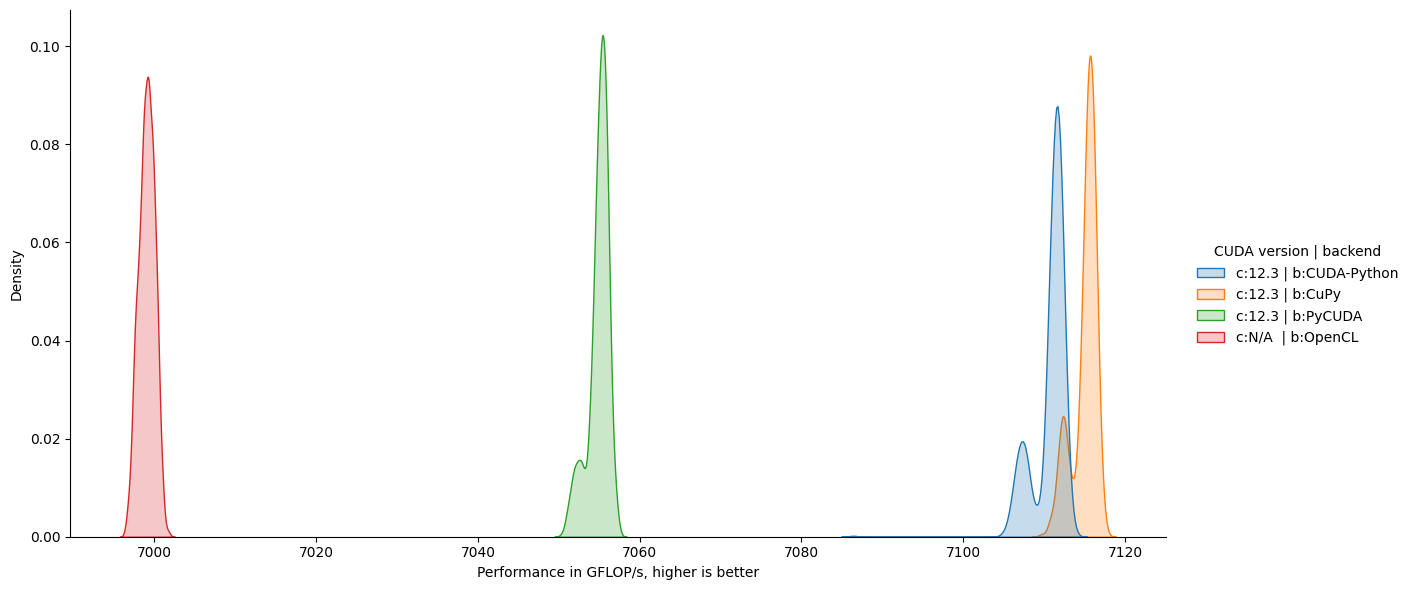

In [ ]:
g = sns.displot(data=df_no_flush, x='GFLOP/s', hue='CUDA version | backend', kind='kde', fill=True, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Performance in GFLOP/s, higher is better")

Instead of looking at the average time per configuration over its 32 iterations, we can also look at those 32 iterations individually. In the above plot, we can see the 32 iterations for a configuration for each of the four backends. It is notable here that for the CUDA backends, the first iteration has worst performance. 

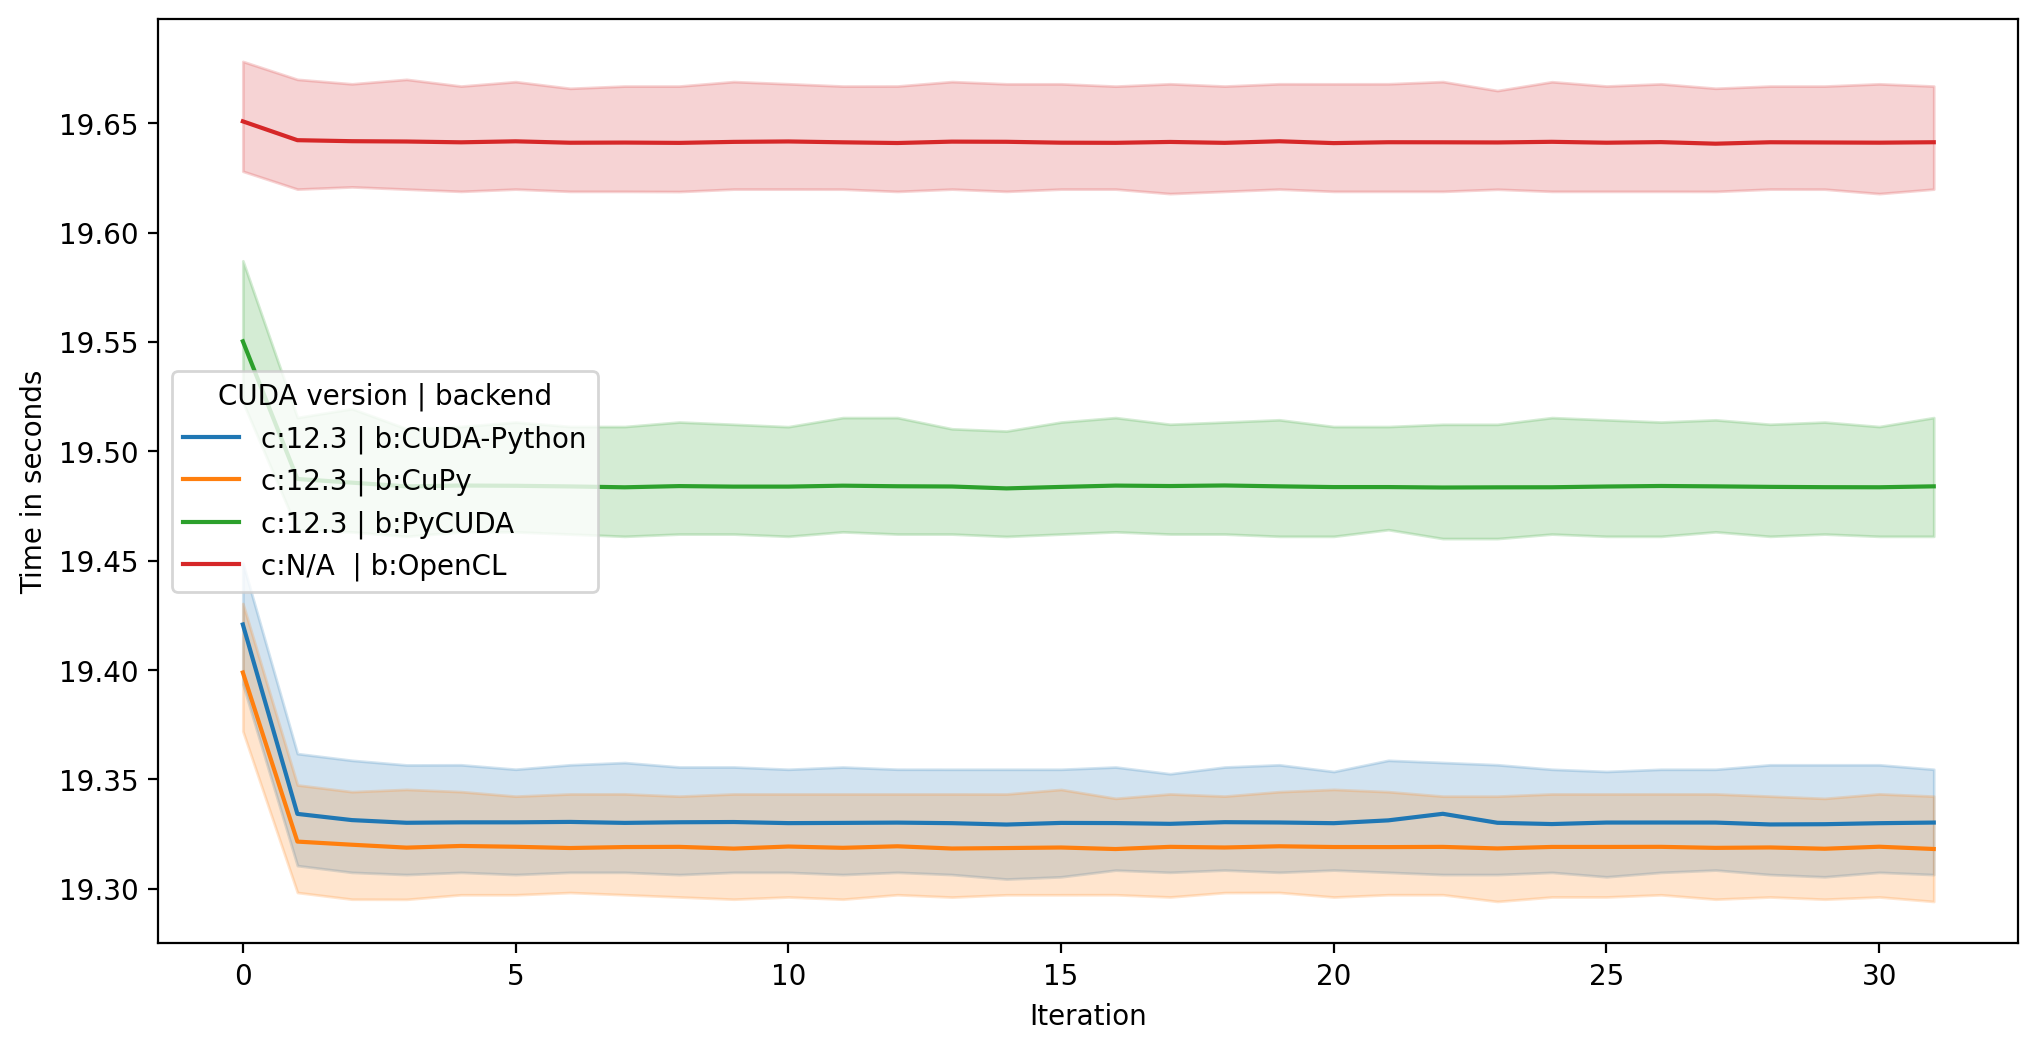

In [ ]:
df_no_flush_times = plot_combined_times(df_no_flush)

If instead of one individual configuration we look at all 1000 configurations per backend combined, it is clear that this is a stable phenomenon. Note that the area of spread is the 95% percentage interval. 

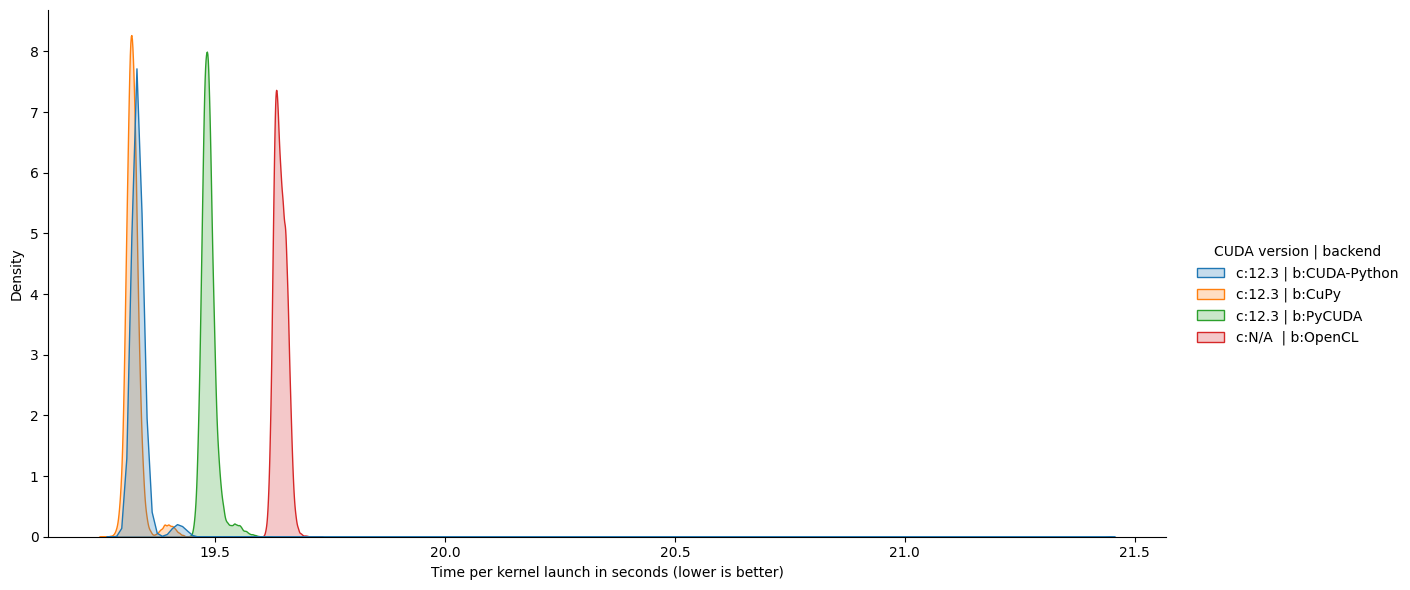

In [ ]:
plot_histogram_times(df_no_flush_times)

In this distribution plot, the first kernel launch being slower shows as the "bump" on the right-hand side of the main column for each CUDA backend. The cause of this first iteration being slower is that the L2 cache was not invalidated after the first kernel launch as no data was copied. To remedy this, we added an observer which resets the L2 cache in between kernel launches. 

We can now re-run the tests and visualize the data in the same way to show that the effects have been strongly reduced:

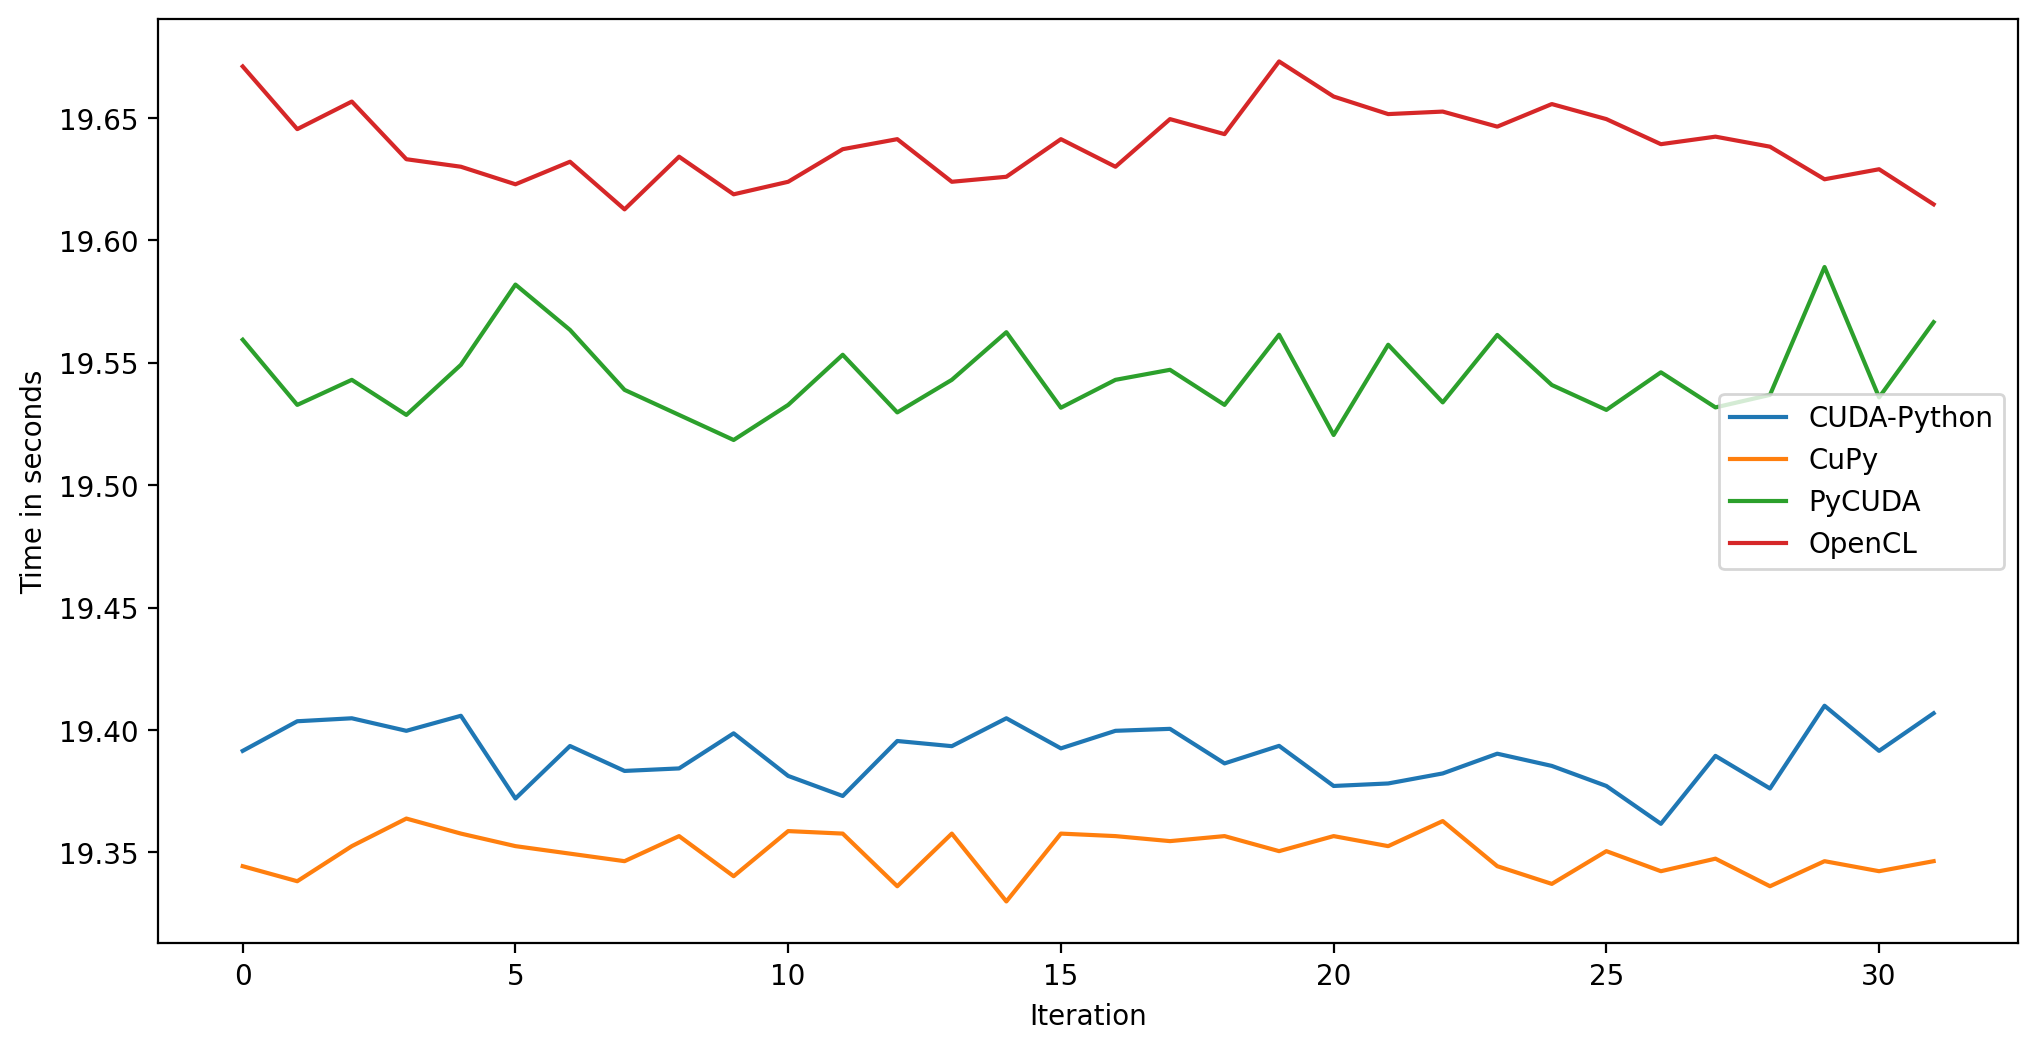

In [ ]:
plot_individual_times(df)

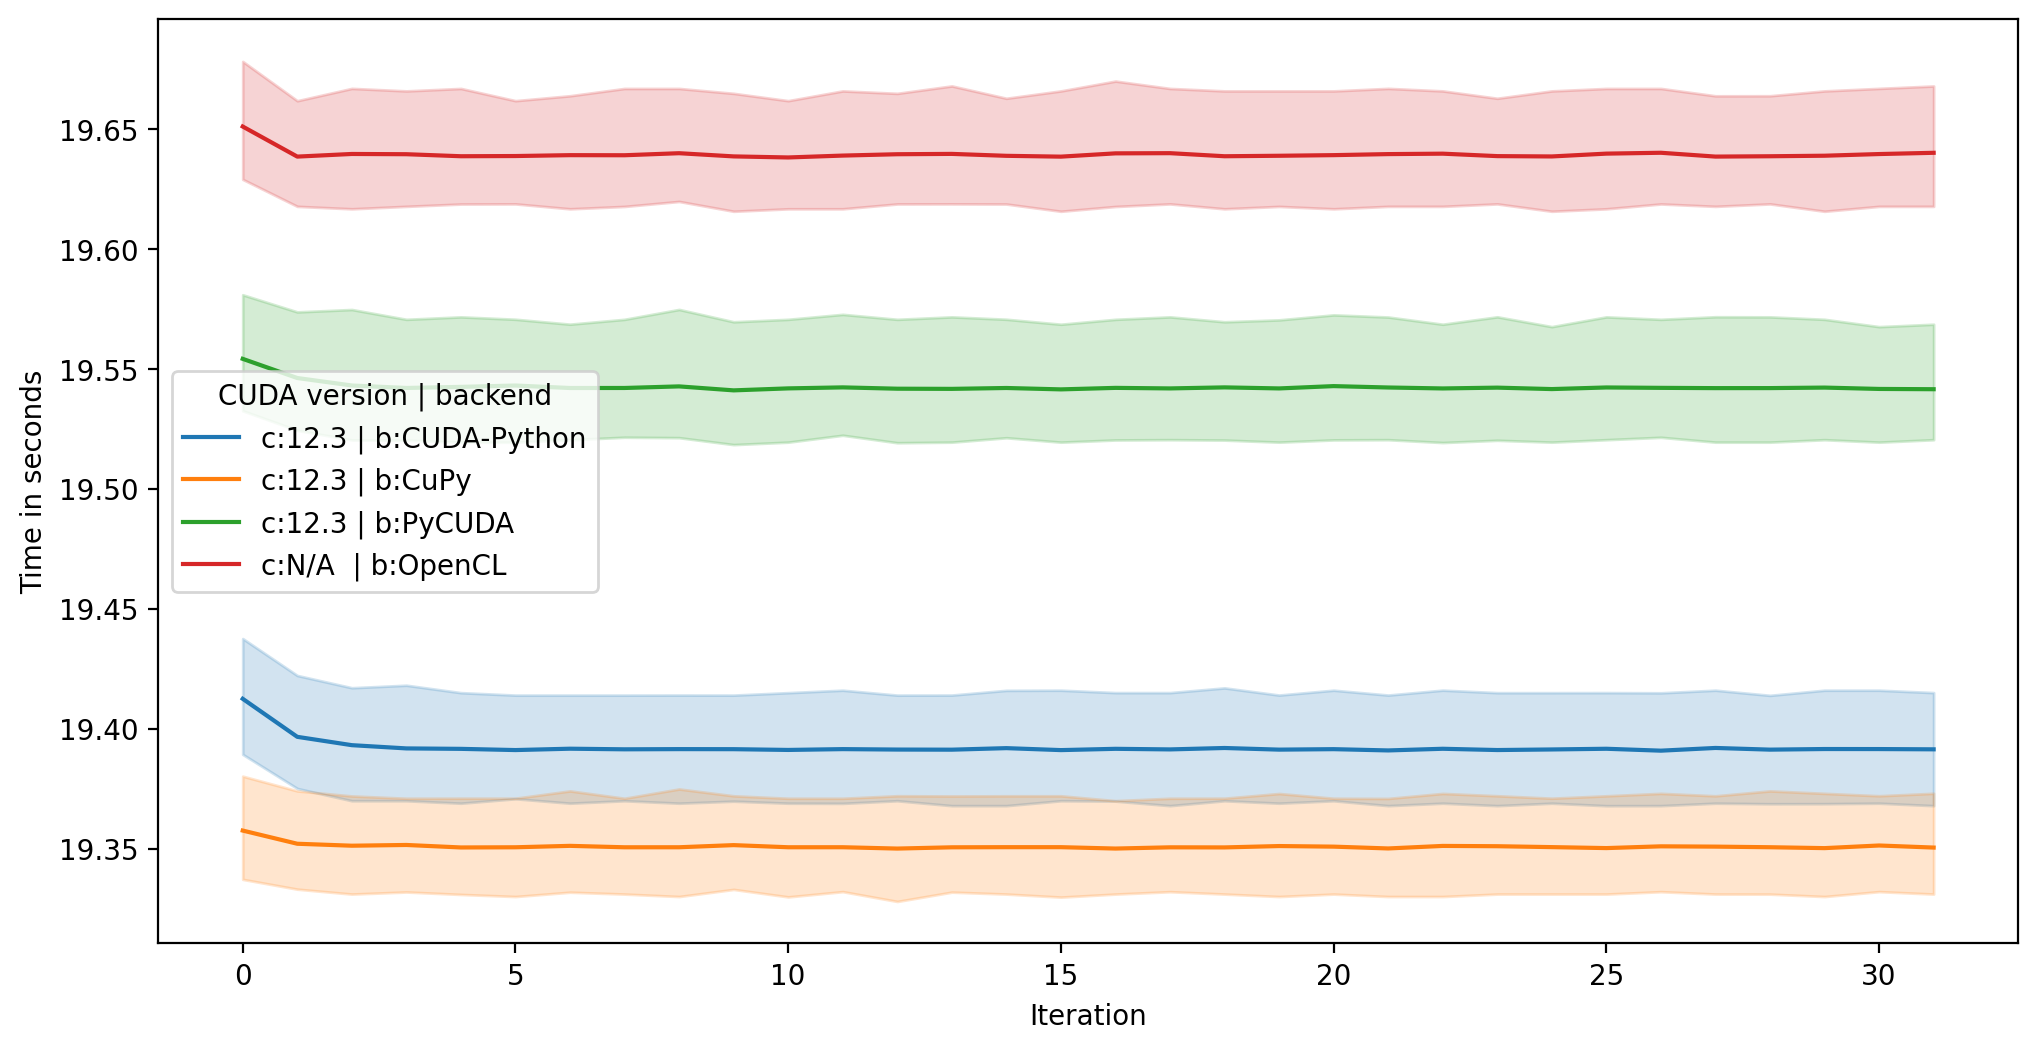

In [ ]:
df_times = plot_combined_times(df)

Though strongly reduced, the effect has not entirely been removed. 

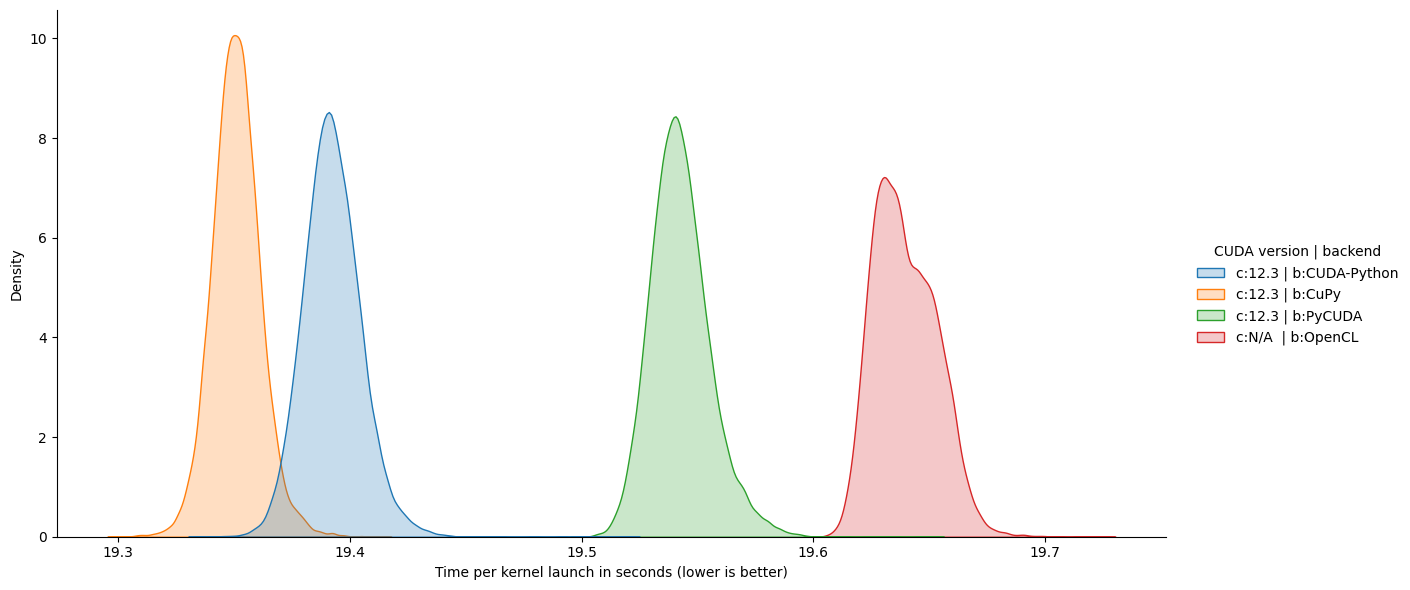

In [ ]:
plot_histogram_times(df_times)

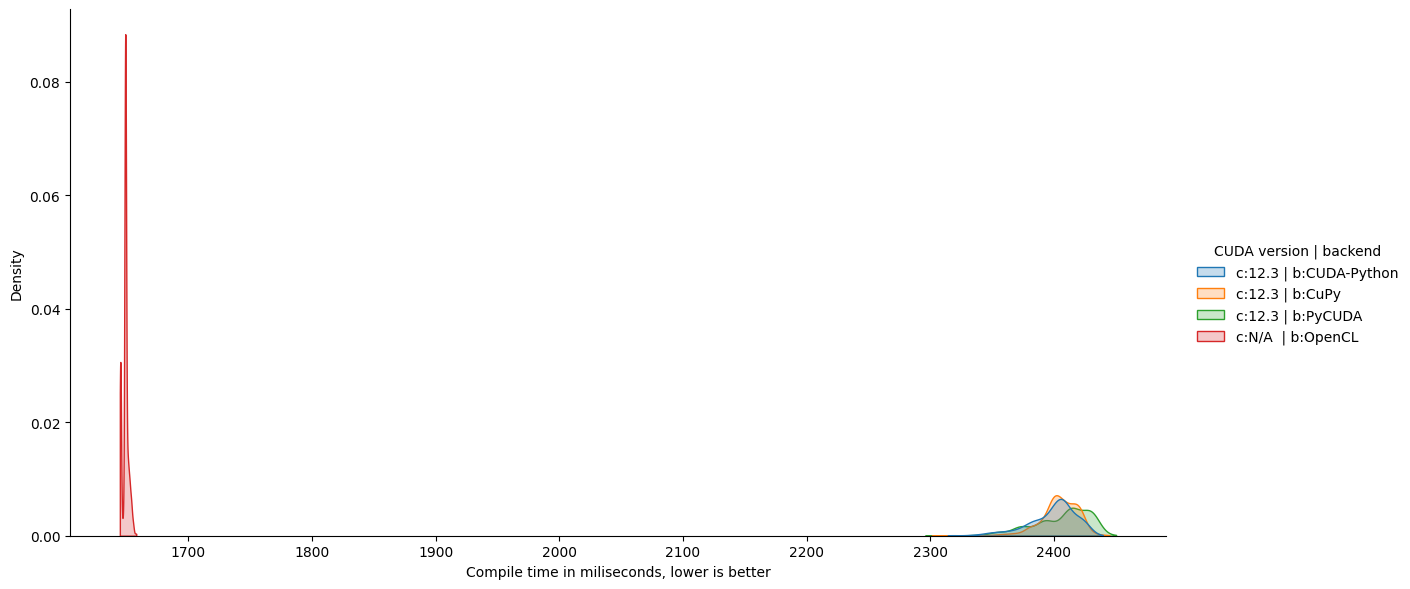

In [ ]:
g = sns.displot(data=df_no_flush, x='benchmark_time', hue='CUDA version | backend', kind='kde', fill=True, height=plot_height, aspect=plot_aspect, cut=0)
g = g.set_xlabels("Compile time in miliseconds, lower is better")